C:\Users\arend\AppData\Local\Temp\ipykernel_5404\820349368.py:256: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


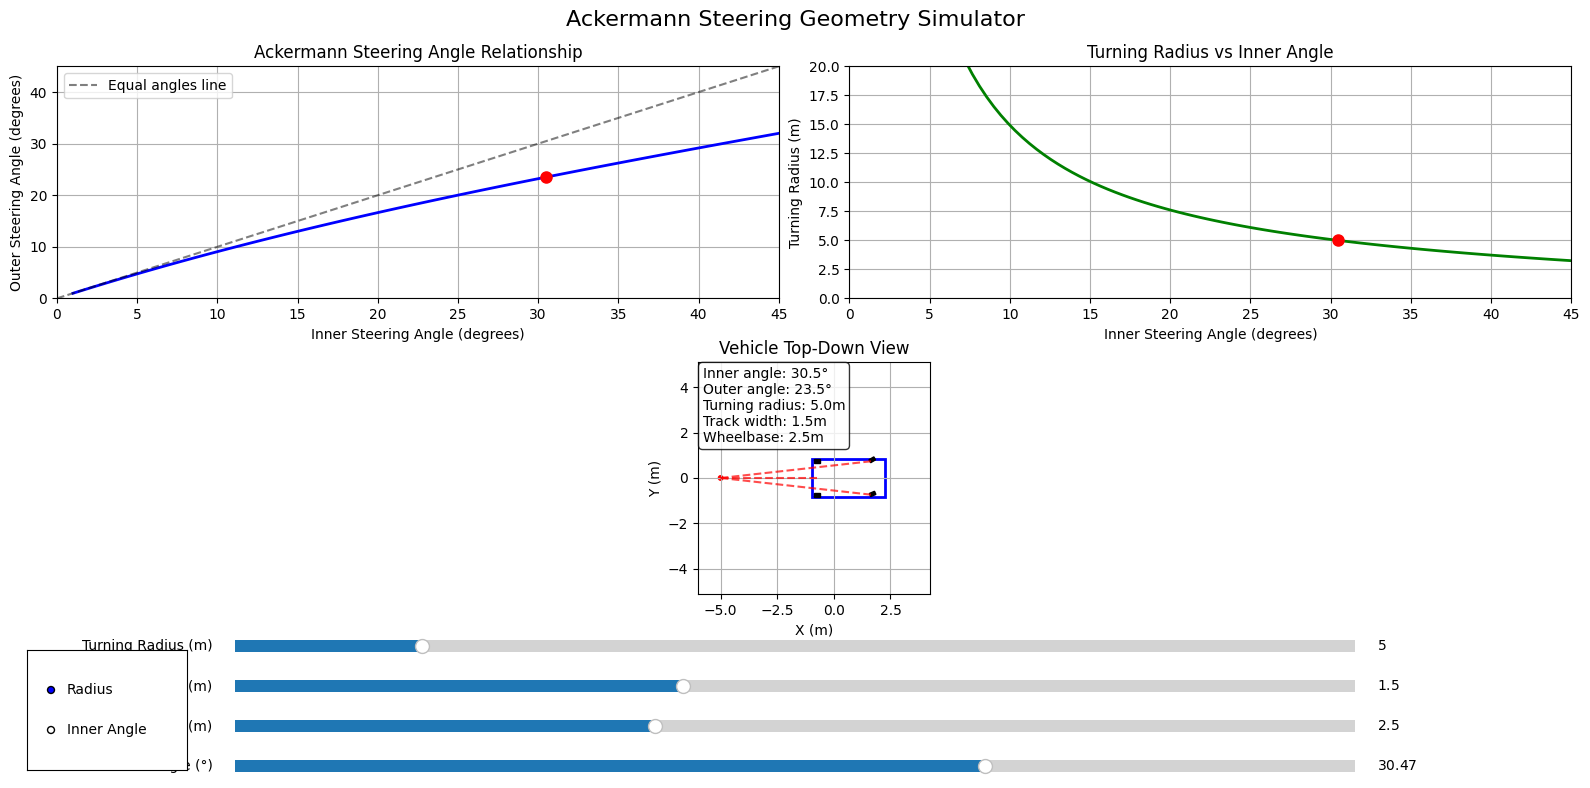

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, RadioButtons
from matplotlib.patches import Rectangle, Circle, Arrow

# Initial parameters
wheelbase = 2.5  # L (m)
track_width = 1.5  # B (m)
turning_radius = 5.0  # R (m) to outside wheel

# Function to calculate the corresponding angle using the Ackermann relationship
def calculate_inner_outer_angles(turning_radius, wheelbase, track_width):
    """Calculate both inner and outer angles based on turning radius"""
    # For a given turning radius to the center of the rear axle
    # Geometry: turning radius is measured to the center of the rear axle
    R = turning_radius
    L = wheelbase
    B = track_width
    
    # Calculate angles based on the turning geometry
    # Inner angle is larger than outer angle
    # Inner wheel angle (δi)
    inner_angle_rad = np.arctan(L / (R - B/2))
    # Outer wheel angle (δo)
    outer_angle_rad = np.arctan(L / (R + B/2))
    
    return np.rad2deg(inner_angle_rad), np.rad2deg(outer_angle_rad)

def calculate_outer_angle(inner_angle, B, L):
    """Calculate outer angle from inner angle using Ackermann relationship"""
    # Convert degrees to radians
    inner_rad = np.deg2rad(inner_angle)
    # Apply the Ackermann relationship: cot(δo) - cot(δi) = B/L
    cot_inner = 1 / np.tan(inner_rad)
    cot_outer = cot_inner + B/L
    # Handle potential numerical issues
    if np.abs(cot_outer) < 1e-10:
        outer_rad = np.pi/2 if cot_outer >= 0 else -np.pi/2
    else:
        outer_rad = np.arctan(1 / cot_outer)
    return np.rad2deg(outer_rad)

def calculate_turning_radius(inner_angle, B, L):
    """Calculate turning radius to center of rear axle from inner angle"""
    inner_rad = np.deg2rad(inner_angle)
    # Inner wheel radius: Ri = L/tan(δi)
    Ri = L / np.tan(inner_rad)
    # Distance from center of turn to centerline of vehicle
    R = Ri + B/2
    return R

def plot_vehicle(ax, wheelbase, track_width, inner_angle, outer_angle, turning_radius):
    """Draw the vehicle with wheels at the correct angles"""
    ax.clear()
    # Plot parameters
    car_length = wheelbase * 1.3  # Car extends beyond wheelbase
    car_width = track_width * 1.1
    wheel_width = track_width * 0.1
    wheel_length = wheelbase * 0.1
    
    # Draw car body
    car_body = Rectangle((-car_length * 0.3, -car_width/2), car_length, car_width, 
                        fill=False, edgecolor='blue', linewidth=2)
    ax.add_patch(car_body)
    
    # Draw wheels
    # Front left wheel (inner wheel during right turn)
    fl_wheel = Rectangle((wheelbase * 0.7 - wheel_length/2, track_width/2 - wheel_width/2), 
                        wheel_length, wheel_width, 
                        angle=inner_angle, fill=True, color='black')
    # Front right wheel (outer wheel during right turn)
    fr_wheel = Rectangle((wheelbase * 0.7 - wheel_length/2, -track_width/2 - wheel_width/2), 
                        wheel_length, wheel_width, 
                        angle=outer_angle, fill=True, color='black')
    # Rear wheels (straight)
    rl_wheel = Rectangle((-wheelbase * 0.3 - wheel_length/2, track_width/2 - wheel_width/2), 
                        wheel_length, wheel_width, fill=True, color='black')
    rr_wheel = Rectangle((-wheelbase * 0.3 - wheel_length/2, -track_width/2 - wheel_width/2), 
                        wheel_length, wheel_width, fill=True, color='black')
    
    ax.add_patch(fl_wheel)
    ax.add_patch(fr_wheel)
    ax.add_patch(rl_wheel)
    ax.add_patch(rr_wheel)
    
    # Draw turning center and turning radius
    # Calculate coordinates of turning center
    x_tc = -turning_radius
    y_tc = 0
    # Draw turning center point
    ax.add_patch(Circle((x_tc, y_tc), 0.1, color='red'))
    
    # Draw turning radii lines
    # To center of rear axle
    ax.plot([x_tc, -wheelbase * 0.3], [y_tc, 0], 'r--', alpha=0.7)
    # To inner wheel
    ax.plot([x_tc, wheelbase * 0.7], [y_tc, track_width/2], 'r--', alpha=0.7)
    # To outer wheel
    ax.plot([x_tc, wheelbase * 0.7], [y_tc, -track_width/2], 'r--', alpha=0.7)
    
    # Set axis properties
    max_dim = max(car_length, car_width) + turning_radius + 2
    ax.set_xlim(-turning_radius - 1, car_length + 1)
    ax.set_ylim(-max_dim/2, max_dim/2)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_title('Vehicle Top-Down View')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    
    # Add text with angles and turning radius
    text_info = f"Inner angle: {inner_angle:.1f}°\nOuter angle: {outer_angle:.1f}°\n"
    text_info += f"Turning radius: {turning_radius:.1f}m\nTrack width: {track_width:.1f}m\nWheelbase: {wheelbase:.1f}m"
    ax.text(0.02, 0.98, text_info, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Create the figure and subplots
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

ax_graph = fig.add_subplot(gs[0, 0])  # Top left - angle relationship graph
ax_turning = fig.add_subplot(gs[0, 1])  # Top right - turning radius vs inner angle
ax_vehicle = fig.add_subplot(gs[1, :])  # Bottom - vehicle visualization

plt.subplots_adjust(bottom=0.25, wspace=0.3, hspace=0.3)

# Calculate initial angles based on turning radius
inner_angle_init, outer_angle_init = calculate_inner_outer_angles(turning_radius, wheelbase, track_width)

# Set up angle relationship graph (top left)
inner_angles = np.linspace(1, 45, 100)  # degrees
outer_angles = [calculate_outer_angle(inner, track_width, wheelbase) for inner in inner_angles]
angle_plot, = ax_graph.plot(inner_angles, outer_angles, 'b-', linewidth=2)
angle_marker, = ax_graph.plot([inner_angle_init], [outer_angle_init], 'ro', markersize=8)

ax_graph.set_xlabel('Inner Steering Angle (degrees)')
ax_graph.set_ylabel('Outer Steering Angle (degrees)')
ax_graph.set_title('Ackermann Steering Angle Relationship')
ax_graph.grid(True)
ax_graph.plot([0, 45], [0, 45], 'k--', alpha=0.5, label='Equal angles line')
ax_graph.legend()
ax_graph.set_xlim(0, 45)
ax_graph.set_ylim(0, 45)

# Set up turning radius graph (top right)
turning_radii = [calculate_turning_radius(inner, track_width, wheelbase) for inner in inner_angles]
radius_plot, = ax_turning.plot(inner_angles, turning_radii, 'g-', linewidth=2)
radius_marker, = ax_turning.plot([inner_angle_init], [turning_radius], 'ro', markersize=8)

ax_turning.set_xlabel('Inner Steering Angle (degrees)')
ax_turning.set_ylabel('Turning Radius (m)')
ax_turning.set_title('Turning Radius vs Inner Angle')
ax_turning.grid(True)
ax_turning.set_xlim(0, 45)
ax_turning.set_ylim(0, 20)

# Initial vehicle plot
plot_vehicle(ax_vehicle, wheelbase, track_width, inner_angle_init, outer_angle_init, turning_radius)

# Add sliders for parameters
ax_turning_radius = plt.axes([0.15, 0.17, 0.7, 0.03])
turning_radius_slider = Slider(ax_turning_radius, 'Turning Radius (m)', 2.0, 20.0, valinit=turning_radius)

ax_track_width = plt.axes([0.15, 0.12, 0.7, 0.03])
track_width_slider = Slider(ax_track_width, 'Track Width (m)', 0.5, 3.0, valinit=track_width)

ax_wheelbase = plt.axes([0.15, 0.07, 0.7, 0.03])
wheelbase_slider = Slider(ax_wheelbase, 'Wheelbase (m)', 1.0, 5.0, valinit=wheelbase)

ax_inner_angle = plt.axes([0.15, 0.02, 0.7, 0.03])
inner_angle_slider = Slider(ax_inner_angle, 'Inner Angle (°)', 1.0, 45.0, valinit=inner_angle_init)

# Radio buttons for control mode (what parameter to focus on changing)
ax_radio = plt.axes([0.02, 0.03, 0.1, 0.15])
radio = RadioButtons(ax_radio, ('Radius', 'Inner Angle'), active=0)

# Global variable to prevent recursive callbacks
updating = False
mode = 'Radius'  # Initial mode

def update_plots():
    """Update all plots based on current parameter values"""
    global updating, wheelbase, track_width, turning_radius
    
    if updating:
        return  # Avoid recursion
    
    updating = True  # Set lock
    
    # Get current values
    track_width = track_width_slider.val
    wheelbase = wheelbase_slider.val
    
    if mode == 'Radius':
        # In radius mode, turning radius controls everything
        turning_radius = turning_radius_slider.val
        inner_angle, outer_angle = calculate_inner_outer_angles(turning_radius, wheelbase, track_width)
        # Update inner angle slider without triggering callback
        inner_angle_slider.set_val(inner_angle)
    else:  # 'Inner Angle'
        # In inner angle mode, inner angle controls everything
        inner_angle = inner_angle_slider.val
        turning_radius = calculate_turning_radius(inner_angle, track_width, wheelbase)
        outer_angle = calculate_outer_angle(inner_angle, track_width, wheelbase)
        # Update turning radius slider without triggering callback
        turning_radius_slider.set_val(turning_radius)
    
    # Update angle graph
    outer_angles = [calculate_outer_angle(inner, track_width, wheelbase) for inner in inner_angles]
    angle_plot.set_ydata(outer_angles)
    angle_marker.set_data([inner_angle], [outer_angle])
    
    # Update turning radius graph
    turning_radii = [calculate_turning_radius(inner, track_width, wheelbase) for inner in inner_angles]
    radius_plot.set_ydata(turning_radii)
    radius_marker.set_data([inner_angle], [turning_radius])
    
    # Update vehicle visualization
    plot_vehicle(ax_vehicle, wheelbase, track_width, inner_angle, outer_angle, turning_radius)
    
    fig.canvas.draw_idle()
    updating = False  # Release lock

def on_radius_change(val):
    """Callback for turning radius slider"""
    if mode == 'Radius':  # Only respond when in Radius mode
        update_plots()

def on_inner_angle_change(val):
    """Callback for inner angle slider"""
    if mode == 'Inner Angle':  # Only respond when in Inner Angle mode
        update_plots()

def on_param_change(val):
    """Callback for track width and wheelbase sliders"""
    update_plots()

def on_mode_change(label):
    """Callback for radio button mode selection"""
    global mode
    mode = label
    update_plots()

# Connect sliders to their respective callback functions
turning_radius_slider.on_changed(on_radius_change)
inner_angle_slider.on_changed(on_inner_angle_change)
track_width_slider.on_changed(on_param_change)
wheelbase_slider.on_changed(on_param_change)
radio.on_clicked(on_mode_change)

# Initial update
update_plots()

plt.suptitle('Ackermann Steering Geometry Simulator', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()